In [ ]:
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow.keras import applications
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets

### **Trained on Kaggle TPU**
#### **Reference for TPU training:https://www.kaggle.com/ragnar123/shopee-efficientnetb3-arcmarginproduct**

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [2]:
def f1_score(actual, predicted):
    # In this problem the evaluation metric is f1-score averaged over the test datapoints.
    avg_f1=0
    for i in range(len(actual)):
        f1=2*(len(set(actual[i]).intersection(set(predicted[i])))/(len(actual[i])+len(predicted[i])))
        avg_f1+=f1
    return avg_f1/len(actual)

In [ ]:
train=pd.read_csv('../input/shopee-product-matching/train.csv')
# Considering label_group as ground truth.
train['targets'] = train['label_group'].map(train.groupby(['label_group'])['posting_id'].unique().to_dict())
print(train.shape)
train.head()

(34250, 6)


,posting_id,image,image_phash,title,label_group,targets
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
GCS_PATH = KaggleDatasets().get_gcs_path('shopee-tf-records-512-stratified')
tf_records=tf.io.gfile.glob(GCS_PATH + '/*.tfrec')

In [ ]:
# Used this Data fetching and Augmentation part of reference

def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'input_image': image, 'label': label_group}, label_group, matches

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    # Normalizing image
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
  # TF records have 4 columnns, tilte is not stored
    LABELED_TFREC_FORMAT = {
        "posting_id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label_group": tf.io.FixedLenFeature([], tf.int64),
        "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['posting_id']
    image = decode_image(example['image'])
    label_group = tf.cast(example['label_group'], tf.int32)
    matches = example['matches']
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, ordered = False):
    dataset = load_dataset(filenames, ordered = ordered)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(tf_records)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 34250 training images


In [ ]:
train_dataset = get_training_dataset(tf_records, ordered = False)
train_dataset = train_dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))

STEPS_PER_EPOCH = count_data_items(tf_records) // BATCH_SIZE
tf.keras.backend.clear_session()

# **1. Training EfficientNetB5 with ArcFace - Cosine Similarity**
Reference Paper: https://arxiv.org/pdf/1801.07698.pdf

*  *ArcFace is a modification to Softmax to make loss depend only on Cosine Similarity(Dot Product) between feature vector and weight vector. Let's consider Sigmoid for example. We know that the Sigmoid Function is 1/(1+exp-(W.X+b)) where X is the feature vector, W is weight and b is the bias term. Let's consider the plane passes through origin i.e. bias=0 for simplicity. Now Sigmoid=1/(1+exp-(W.X)).*

*   *We know that dot(W,X)=||W||.||X||.Cos(angle between them). We compute this and consider this as probability estimation and calculate loss with that. What if we make W and X unit vectors? The loss depends only on angle between those vectors. That is if angle is less(more cosine similar) the loss is less and during training the model updates weights in such a way that it decreases angle between W and X for particular class label.*

*  *In addition to this, What if we add some angle to actual? Even if angle is less, as we are adding certain angle and making vector less cosine similar the model tries to reduce the added angle during training which in-turn update the weights through back propagation in such a way that the actual angle is reduced. We are just making training harder which results in better learning than actual.*

*  *This process of making loss depend on Angle(Cosine Similarity) and adding additional angle to that to improve training efficiency is called* **ArcFace- Additive Angular Margin Loss**

In [ ]:
class ArcFace(tf.keras.layers.Layer):
    
    # Implementation reference from https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py
    
    def __init__(self, n_classes, scale, margin, **kwargs):

        super(ArcFace, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.scale = scale
        self.margin = margin
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)

    def get_config(self):

        config = super().get_config().copy()
        config.update({'n_classes': self.n_classes,'scale': self.scale,'margin': self.margin})
        return config

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)

        # Normalizing vectors( Unit Vectors ) to make dot product depend only on angle between vectors.
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )

        # Sin(angle)^2 + Cos(angle)^2 = 1
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        
        # Cos(angle+margin)=Cos(angle)*Cos(margin)-Sin(angle)*Sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m

        # Add margin only when angle in greater than 90 degrees(Cos(90)=0)
        phi = tf.where(cosine > 0, phi, cosine)

        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes),dtype=cosine.dtype)
    
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        #
        output *= self.scale
        return output

In [ ]:
def get_model():

    with strategy.scope():
        
        image_size=(512,512,3)

        inp_image=tf.keras.layers.Input(shape=(image_size), dtype=tf.float32, name="input_image")
        label=tf.keras.layers.Input(shape = (), name = 'label')

        efn=applications.EfficientNetB5(weights = 'imagenet', include_top = False, input_shape=image_size, pooling='avg')(inp_image)

        # margin=0.35 radians= 20 degrees approx, scale=30
        arc_face=ArcFace(train['label_group'].nunique(),30,0.35, dtype='float32')([efn, label])

        out=tf.keras.layers.Softmax(dtype='float32')(arc_face)

        EFNet_ArcFace_model=tf.keras.models.Model(inputs=[inp_image,label], outputs=out)

        EFNet_ArcFace_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=[tf.keras.losses.SparseCategoricalCrossentropy()], metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        return EFNet_ArcFace_model
EFNet_ArcFace_model=get_model()
EFNet_ArcFace_model.summary()

115269632/115263384 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb5 (Functional)     (None, 2048)         28513527    input_image[0][0]                
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
arc_face (ArcFace)              (None, 11014)        22556672    efficientnetb5[0][0]             
                           

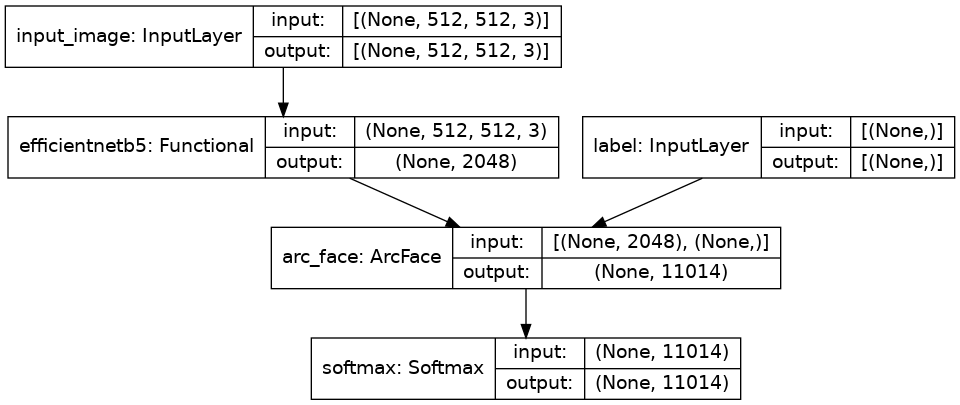

In [ ]:
tf.keras.utils.plot_model(EFNet_ArcFace_model, show_shapes=True)

In [ ]:
class save(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        #saving model on every epoch and loss reduces to 0.5
        if logs.get('loss')<0.5:
            filepath='EFNet_ArcFace_epoch_'+str(epoch+1)+'.hdf5'
            self.model.save_weights(filepath)
        
save=save()

In [ ]:
def scheduler(epoch, lr):
    learning_rate=lr
    # decrease learning rate by 20% for every 10 epochs
    if (epoch+1)%10==0:
        learning_rate=learning_rate*0.8
    return learning_rate
adap_lr=tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
EFNet_ArcFace_model.fit(train_dataset,steps_per_epoch = STEPS_PER_EPOCH,epochs = 75, callbacks=[save, adap_lr])

Epoch 1/75
133/133 [==============================] - 293s 1s/step - loss: 13.7527 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/75
133/133 [==============================] - 158s 1s/step - loss: 14.1256 - sparse_categorical_accuracy: 2.2240e-04
Epoch 3/75
133/133 [==============================] - 158s 1s/step - loss: 14.9352 - sparse_categorical_accuracy: 0.0060
Epoch 4/75
133/133 [==============================] - 155s 1s/step - loss: 13.6919 - sparse_categorical_accuracy: 0.0259
Epoch 5/75
133/133 [==============================] - 158s 1s/step - loss: 12.0011 - sparse_categorical_accuracy: 0.0554
Epoch 6/75
133/133 [==============================] - 158s 1s/step - loss: 10.4286 - sparse_categorical_accuracy: 0.0937
Epoch 7/75
133/133 [==============================] - 157s 1s/step - loss: 9.0701 - sparse_categorical_accuracy: 0.1382
Epoch 8/75
133/133 [==============================] - 157s 1s/step - loss: 7.8245 - sparse_categorical_accuracy: 0.1879
Epoch 9/75
133/133 [======

In [ ]:
effb5_embedder_75_epochs=tf.keras.models.Model(inputs=EFNet_ArcFace_model.layers[1].input, outputs=EFNet_ArcFace_model.layers[1].output)
effb5_embedder_75_epochs.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [ ]:
effb5_embedder_75_epochs.save('./effb5_embedder_75_epochs.h5')

# **2. Training ResNet50 with ArcFace - Cosine Similarity**

In [ ]:
def get_model():

    with strategy.scope():
        
        image_size=(512,512,3)

        inp_image=tf.keras.layers.Input(shape=(image_size), dtype=tf.float32, name="input_image")
        label=tf.keras.layers.Input(shape = (), name = 'label')

        res=applications.ResNet50(weights = 'imagenet', include_top = False, input_shape=image_size, pooling='avg')(inp_image)

        # margin=0.35 radians= 20 degrees approx, scale=30
        arc_face=ArcFace(train['label_group'].nunique(),30,0.35, dtype='float32')([res, label])

        out=tf.keras.layers.Softmax(dtype='float32')(arc_face)

        ResNet_ArcFace_model=tf.keras.models.Model(inputs=[inp_image,label], outputs=out)

        ResNet_ArcFace_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=[tf.keras.losses.SparseCategoricalCrossentropy()], metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        return ResNet_ArcFace_model
ResNet_ArcFace_model=get_model()
ResNet_ArcFace_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 2048)         23587712    input_image[0][0]                
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
arc_face (ArcFace)              (None, 11014)        22556672    resnet50[0][0]                   
                             

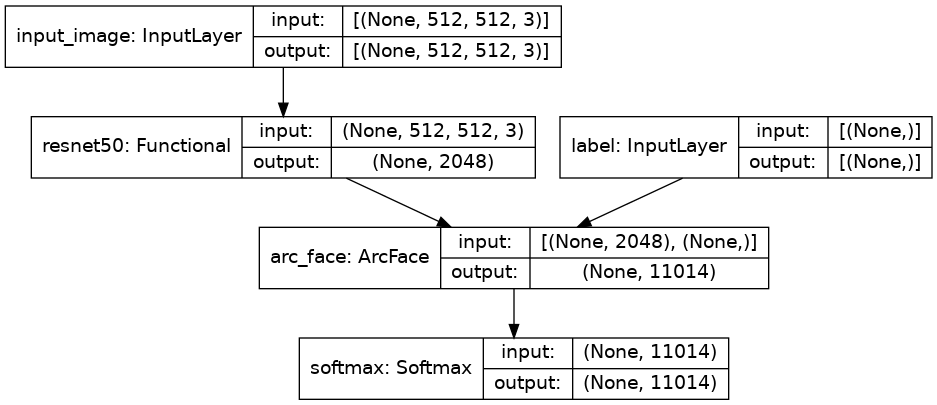

In [ ]:
tf.keras.utils.plot_model(ResNet_ArcFace_model, show_shapes=True)

In [ ]:
class save(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        #saving model on every epoch and loss reduces to 0.5
        if logs.get('loss')<0.5:
            filepath='ResNet_ArcFace_epoch_'+str(epoch+1)+'.hdf5'
            self.model.save_weights(filepath)
        
save=save()

In [ ]:
ResNet_ArcFace_model.fit(train_dataset,steps_per_epoch = STEPS_PER_EPOCH,epochs = 100, callbacks=[save, adap_lr])

Epoch 1/100
133/133 [==============================] - 137s 603ms/step - loss: 11.1963 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
133/133 [==============================] - 86s 646ms/step - loss: 8.7515 - sparse_categorical_accuracy: 0.0068
Epoch 3/100
133/133 [==============================] - 81s 610ms/step - loss: 7.3884 - sparse_categorical_accuracy: 0.0885
Epoch 4/100
133/133 [==============================] - 85s 637ms/step - loss: 6.6832 - sparse_categorical_accuracy: 0.2078
Epoch 5/100
133/133 [==============================] - 86s 645ms/step - loss: 6.3354 - sparse_categorical_accuracy: 0.3105
Epoch 6/100
133/133 [==============================] - 87s 655ms/step - loss: 6.3328 - sparse_categorical_accuracy: 0.3559
Epoch 7/100
133/133 [==============================] - 84s 635ms/step - loss: 6.5541 - sparse_categorical_accuracy: 0.3460
Epoch 8/100
133/133 [==============================] - 83s 621ms/step - loss: 6.7423 - sparse_categorical_accuracy: 0.3218
Epoch 9/10

In [ ]:
ResNet_ArcFace_model.load_weights('./ResNet_ArcFace_epoch_50.hdf5')

In [ ]:
ResNet50_embedder_50_epochs=tf.keras.models.Model(inputs=ResNet_ArcFace_model.layers[1].input, outputs=ResNet_ArcFace_model.layers[1].output)
ResNet50_embedder_50_epochs.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
ResNet50_embedder_50_epochs.save('./ResNet50_embedder_50_epochs.h5')

# **3. Training EfficientNetB5 with ArcFace - different Margin approach**
**In previous models, margin angle is added only when angle between vectors(feature and weight) is greater than 90 degress. But now I am adding margin irrespective of angle between vectors train the model.**

In [ ]:
class ArcFace(tf.keras.layers.Layer):
    
    # Implementation reference from https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py
    
    def __init__(self, n_classes, scale, margin, **kwargs):

        super(ArcFace, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.scale = scale
        self.margin = margin
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        

    def get_config(self):

        config = super().get_config().copy()
        config.update({'n_classes': self.n_classes,'scale': self.scale,'margin': self.margin})
        return config

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)

        # Normalizing vectors( Unit Vectors ) to make dot product depend only on angle between vectors.
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )

        # Sin(angle)^2 + Cos(angle)^2 = 1
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        
        # Cos(angle+margin)=Cos(angle)*Cos(margin)-Sin(angle)*Sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m

        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes),dtype=cosine.dtype)
    
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        #
        output *= self.scale
        return output

In [ ]:
def get_model():

    with strategy.scope():
        
        image_size=(512,512,3)

        inp_image=tf.keras.layers.Input(shape=(image_size), dtype=tf.float32, name="input_image")
        label=tf.keras.layers.Input(shape = (), name = 'label')

        efn=applications.EfficientNetB5(weights = 'imagenet', include_top = False, input_shape=image_size, pooling='avg')(inp_image)

        # margin=0.35 radians = 20 degrees approx, scale=30
        arc_face=ArcFace(train['label_group'].nunique(),30,0.35, dtype='float32')([efn, label])

        out=tf.keras.layers.Softmax(dtype='float32')(arc_face)

        EFNet_ArcFace_model_2=tf.keras.models.Model(inputs=[inp_image,label], outputs=out)

        EFNet_ArcFace_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=[tf.keras.losses.SparseCategoricalCrossentropy()], metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        return EFNet_ArcFace_model_2
EFNet_ArcFace_model_2=get_model()
EFNet_ArcFace_model_2.summary()

115269632/115263384 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb5 (Functional)     (None, 2048)         28513527    input_image[0][0]                
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
arc_face (ArcFace)              (None, 11014)        22556672    efficientnetb5[0][0]             
                           

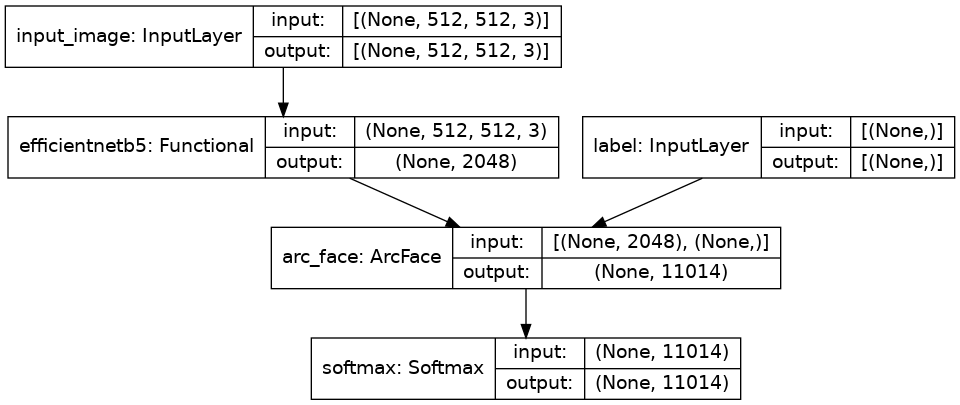

In [ ]:
tf.keras.utils.plot_model(EFNet_ArcFace_model_2, show_shapes=True)

In [ ]:
class save(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        #saving model on every epoch
        if logs.get('loss')<0.5:
            filepath='EfNet2_ArcFace_epoch_'+str(epoch+1)+'.hdf5'
            self.model.save_weights(filepath)
        
save=save()

In [ ]:
EFNet_ArcFace_model_2.fit(train_dataset,steps_per_epoch = STEPS_PER_EPOCH,epochs = 100, callbacks=[save, adap_lr])

Epoch 1/100
133/133 [==============================] - 308s 1s/step - loss: 19.5896 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/100
133/133 [==============================] - 155s 1s/step - loss: 17.6251 - sparse_categorical_accuracy: 1.7410e-04
Epoch 3/100
133/133 [==============================] - 157s 1s/step - loss: 15.6659 - sparse_categorical_accuracy: 0.0060
Epoch 4/100
133/133 [==============================] - 156s 1s/step - loss: 13.7542 - sparse_categorical_accuracy: 0.0268
Epoch 5/100
133/133 [==============================] - 157s 1s/step - loss: 11.9949 - sparse_categorical_accuracy: 0.0556
Epoch 6/100
133/133 [==============================] - 158s 1s/step - loss: 10.4597 - sparse_categorical_accuracy: 0.0928
Epoch 7/100
133/133 [==============================] - 155s 1s/step - loss: 9.0348 - sparse_categorical_accuracy: 0.1374
Epoch 8/100
133/133 [==============================] - 156s 1s/step - loss: 7.8539 - sparse_categorical_accuracy: 0.1875
Epoch 9/100
133/13

In [ ]:
EFNet_ArcFace_model_2.load_weights('EfNet2_ArcFace_epoch_50.hdf5')

In [ ]:
EFNetb5_2_embedder_50_epochs=tf.keras.models.Model(inputs=EFNet_ArcFace_model_2.layers[1].input, outputs=EFNet_ArcFace_model_2.layers[1].output)
EFNetb5_2_embedder_50_epochs.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 512, 512, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [ ]:
EFNetb5_2_embedder_50_epochs.save('EFNetb5_2_embedder_50_epochs.h5')

# **4. Training EfficientNetB3 with ArcFace with different Margin**
**In model 3(above), margin angle is added irrespective of angle between vectors(feature and weights). But here margin is added in every scenario but varies according to angle between feature and weights. Margin is larger when angle is small and vice-versa. Check the code in ArcFace for explanation. Also using EfficientNet B3 which has less parameters and increased margin to 30 degrees(0.52 radians)**

In [ ]:
class ArcFace(tf.keras.layers.Layer):
    
    # Implementation reference from https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py
    
    def __init__(self, n_classes, scale, margin, **kwargs):

        super(ArcFace, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.scale = scale
        self.margin = margin
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        
        # Cos(180-margin)
        self.threshold = tf.math.cos(math.pi - margin)
        # let margin=30 degress =0.52 radians, then minimum_margin= sin(180-30)*0.52 = 0.26
        self.minimum_margin = tf.math.sin(math.pi - margin) * margin

    def get_config(self):

        config = super().get_config().copy()
        config.update({'n_classes': self.n_classes,'scale': self.scale,'margin': self.margin})
        return config

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)

        # Normalizing vectors( Unit Vectors ) to make dot product depend only on angle between vectors.
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )

        # Sin(angle)^2 + Cos(angle)^2 = 1
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        
        # Cos(angle+margin)=Cos(angle)*Cos(margin)-Sin(angle)*Sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        # Smaller the angle between feature vector and weight vector, larger the margin and vice versa
        # let theta be angle between feature vector and weight vector
        # let theta=20 degrees, phi= Cos(30)-minimum_margin = 0.606. angle=inv_cos(0.606)= 52 degrees --> margin_added= 22 degrees (approx)
        # let theta=40 degrees, phi= Cos(40)-minimum_margin = 0.506. angle=inv_cos(0.506)= 59 degrees --> margin_added= 19 degrees (approx)
        # let theta=70 degrees, phi= Cos(70)-minimum_margin = 0.082. angle=inv_cos(0.082)= 85 degrees --> margin_added= 15 degrees (approx)
        phi = tf.where(cosine > self.threshold, phi, cosine - self.minimum_margin)

        one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes),dtype=cosine.dtype)
    
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        #
        output *= self.scale
        return output

In [ ]:
def get_model():

    with strategy.scope():
        
        image_size=(512,512,3)

        inp_image=tf.keras.layers.Input(shape=(image_size), dtype=tf.float32, name="input_image")
        label=tf.keras.layers.Input(shape = (), name = 'label')

        efn=applications.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape=image_size, pooling='avg')(inp_image)

        # margin=0.52 radians = 30 degrees approx, scale=30
        arc_face=ArcFace(train['label_group'].nunique(),30,0.52, dtype='float32')([efn, label])

        out=tf.keras.layers.Softmax(dtype='float32')(arc_face)

        EFNet_ArcFace_model_3=tf.keras.models.Model(inputs=[inp_image,label], outputs=out)

        EFNet_ArcFace_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss=[tf.keras.losses.SparseCategoricalCrossentropy()], metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        return EFNet_ArcFace_model_3
EFNet_ArcFace_model_3=get_model()
EFNet_ArcFace_model_3.summary()

43941888/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb3 (Functional)     (None, 1536)         10783535    input_image[0][0]                
__________________________________________________________________________________________________
label (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
arc_face (ArcFace)              (None, 11014)        16917504    efficientnetb3[0][0]             
                             

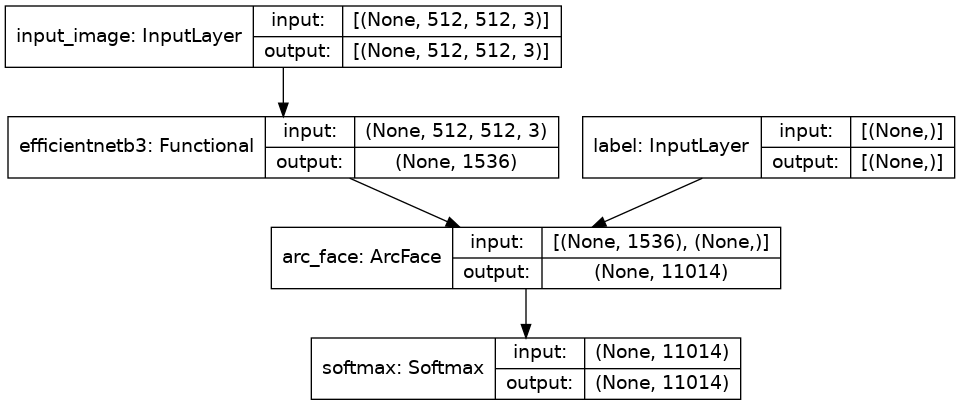

In [ ]:
tf.keras.utils.plot_model(EFNet_ArcFace_model_3, show_shapes=True)

In [ ]:
class save(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        #saving model on every epoch when loss decreases to 0.35
        if logs.get('loss')<0.35:
            filepath='EfNetB3_ArcFace_epoch_'+str(epoch+1)+'.hdf5'
            self.model.save_weights(filepath)
        
save=save()

In [ ]:
def get_lr_callback():
  # Used this from reference 
  # High LR is maintained in initial few epochs and it's gradually decreased. 
    lr_start   = 0.000001
    lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [ ]:
EFNet_ArcFace_model_3.fit(train_dataset,steps_per_epoch = STEPS_PER_EPOCH,epochs = 50, callbacks=[save, get_lr_callback()])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
133/133 - 201s - loss: 23.9597 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00025680000000000006.
133/133 - 105s - loss: 21.6631 - sparse_categorical_accuracy: 2.6433e-04
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005126000000000001.
133/133 - 104s - loss: 16.0437 - sparse_categorical_accuracy: 0.0341
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007684000000000001.
133/133 - 104s - loss: 10.6702 - sparse_categorical_accuracy: 0.1409
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010242.
133/133 - 104s - loss: 7.1291 - sparse_categorical_accuracy: 0.2915
Epoch 6/50

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00128.
133/133 - 105s - loss: 5.2941 - sparse_categorical_accuracy: 0.4124
Epoch 7/50

Epoch 00007: LearningRateSchedule

In [ ]:
EFNetb3_embedder_50_epochs=tf.keras.models.Model(inputs=EFNet_ArcFace_model_3.layers[1].input, outputs=EFNet_ArcFace_model_3.layers[1].output)
EFNetb3_embedder_50_epochs.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [ ]:
EFNetb3_embedder_50_epochs.save('EFNetb3_embedder_50_epochs.h5')

# **Embeddings: In Colab GPU**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import gc
from tqdm import tqdm
import tensorflow as tf

In [5]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/train.csv')
train['image']='/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/train images/'+train.image.values
# Considering label_group as ground truth.
train['targets'] = train['label_group'].map(train.groupby(['label_group'])['posting_id'].unique().to_dict())
print(train.shape)
train.head()

(34250, 6)


,posting_id,image,image_phash,title,label_group,targets
0,train_129225211,/content/drive/MyDrive/Colab Notebooks/Case St...,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,/content/drive/MyDrive/Colab Notebooks/Case St...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,/content/drive/MyDrive/Colab Notebooks/Case St...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,/content/drive/MyDrive/Colab Notebooks/Case St...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,/content/drive/MyDrive/Colab Notebooks/Case St...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [6]:
def read_image(image):
    image = tf.io.read_file(image)
    image= tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image,(512,512))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def get_dataset(image):
    dataset = tf.data.Dataset.from_tensor_slices(image)
    dataset = dataset.map(read_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(128)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [7]:
image_paths=train.image.values.tolist()
image_paths[0:3]

['/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/train images/0000a68812bc7e98c42888dfb1c07da0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/train images/00039780dfc94d01db8676fe789ecd05.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/train images/000a190fdd715a2a36faed16e2c65df7.jpg']

## **1. EfficientNetB5 - ArcFace trained:**

In [ ]:
effb5_embedder_75_epochs=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/effb5_embedder_75_epochs.h5')

In [ ]:
image_embeddings_effb5=[]
chunksize=4098
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for chunk in tqdm(range(chunks)):
    start=chunk*chunksize
    end=min(len(train),start+chunksize)
    images=get_dataset(image_paths[start:end])
    embeddings=effb5_embedder_75_epochs.predict(images)
    image_embeddings_effb5.append(embeddings)
image_embeddings_effb5=np.concatenate(np.array(image_embeddings_effb5))
image_embeddings_effb5.shape

100%|██████████| 9/9 [1:05:19<00:00, 435.55s/it]


(34250, 2048)

In [ ]:
del effb5_embedder_75_epochs, image_paths
gc.collect()

2460

In [ ]:
image_embeddings_effb5=np.array([i/np.linalg.norm(i) for i in tqdm(image_embeddings_effb5)])
image_embeddings_effb5.shape

100%|██████████| 34250/34250 [00:00<00:00, 74951.47it/s]


(34250, 2048)

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.4,0.45,0.5,0.55,0.6,0.65,0.7]:
    effb5_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(image_embeddings_effb5[start:end], np.transpose(image_embeddings_effb5))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            effb5_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,effb5_matches)))

f1_score with cosine similarity threshold as 0.4 is 0.8346984534384481
f1_score with cosine similarity threshold as 0.45 is 0.910415739170504
f1_score with cosine similarity threshold as 0.5 is 0.931729058324702
f1_score with cosine similarity threshold as 0.55 is 0.9251513336728121
f1_score with cosine similarity threshold as 0.6 is 0.9000100159202366
f1_score with cosine similarity threshold as 0.65 is 0.8623688951822716
f1_score with cosine similarity threshold as 0.7 is 0.8169169291272764


### **Optimum threshold we observed with training data: 0.5**
### **Submission: https://www.kaggle.com/chaitanyaboyalla/efficientnet-b5-cosine-similarity**
### **Submission score with 0.5 as threshold: 0.643 (Version 1)**
### **Submission score with 0.7 as threshold: 0.680 (Version 8(pinned) - with weights of 50th epeoch)**

## **2. ResNet50 - ArcFace trained:**

In [ ]:
ResNet50_embedder_50_epochs=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/ResNet50_embedder_50_epochs.h5')

In [ ]:
image_embeddings_resnet50=[]
chunksize=4098
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for chunk in tqdm(range(chunks)):
    start=chunk*chunksize
    end=min(len(train),start+chunksize)
    images=get_dataset(image_paths[start:end])
    embeddings=ResNet50_embedder_50_epochs.predict(images)
    image_embeddings_resnet50.append(embeddings)
image_embeddings_resnet50=np.concatenate(np.array(image_embeddings_resnet50))
image_embeddings_resnet50.shape

100%|██████████| 9/9 [02:24<00:00, 16.05s/it]


(34250, 2048)

In [ ]:
del ResNet50_embedder_50_epochs, image_paths
gc.collect()

19256

In [ ]:
image_embeddings_resnet50=np.array([i/np.linalg.norm(i) for i in tqdm(image_embeddings_resnet50)])
image_embeddings_resnet50.shape

100%|██████████| 34250/34250 [00:00<00:00, 81581.69it/s]


(34250, 2048)

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.4,0.45,0.5,0.55,0.6,0.65,0.7]:
    resnet50_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(image_embeddings_resnet50[start:end], np.transpose(image_embeddings_resnet50))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            resnet50_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,resnet50_matches)))

f1_score with cosine similarity threshold as 0.4 is 0.8346688662761242
f1_score with cosine similarity threshold as 0.45 is 0.943517582569908
f1_score with cosine similarity threshold as 0.5 is 0.9698375095554495
f1_score with cosine similarity threshold as 0.55 is 0.9659833967075919
f1_score with cosine similarity threshold as 0.6 is 0.9519119475792328
f1_score with cosine similarity threshold as 0.65 is 0.9318796571428426
f1_score with cosine similarity threshold as 0.7 is 0.9057916932135934


### **Optimum threshold we observed with training data: 0.5**
### **Submission: https://www.kaggle.com/chaitanyaboyalla/resnet-50-cosine-similarity**
### **Submission score with 0.5 as threshold: 0.625 (Version 1)**
### **Submission score with 0.65 as threshold: 0.669 (Version 6(pinned) - with weigths pf 36th epoch)**

## **3. EfficientNetB5 - ArcFace trained (margin in all scenarios):**

In [ ]:
EFNetb5_2_embedder_50_epochs=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/EFNetb5_2_embedder_50_epochs.h5')

In [ ]:
image_embeddings_effb5=[]
chunksize=4098
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for chunk in tqdm(range(chunks)):
    start=chunk*chunksize
    end=min(len(train),start+chunksize)
    images=get_dataset(image_paths[start:end])
    embeddings=EFNetb5_2_embedder_50_epochs.predict(images)
    image_embeddings_effb5.append(embeddings)
image_embeddings_effb5=np.concatenate(np.array(image_embeddings_effb5))
image_embeddings_effb5.shape

100%|██████████| 9/9 [1:19:53<00:00, 532.57s/it]


(34250, 2048)

In [ ]:
del EFNetb5_2_embedder_50_epochs, image_paths
gc.collect()

50461

In [ ]:
image_embeddings_effb5=np.array([i/np.linalg.norm(i) for i in tqdm(image_embeddings_effb5)])
image_embeddings_effb5.shape

100%|██████████| 34250/34250 [00:00<00:00, 100792.64it/s]


(34250, 2048)

In [ ]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.45,0.5,0.55,0.6,0.65,0.7,0.75]:
    effb5_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(image_embeddings_effb5[start:end], np.transpose(image_embeddings_effb5))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            effb5_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,effb5_matches)))

f1_score with cosine similarity threshold as 0.45 is 0.8610107673219176
f1_score with cosine similarity threshold as 0.5 is 0.8964833869997781
f1_score with cosine similarity threshold as 0.55 is 0.8953032250055633
f1_score with cosine similarity threshold as 0.6 is 0.87219373043894
f1_score with cosine similarity threshold as 0.65 is 0.8376521255241487
f1_score with cosine similarity threshold as 0.7 is 0.7959315785120505
f1_score with cosine similarity threshold as 0.75 is 0.7529152118878623


### **Optimum threshold we observed with training data: 0.5**
### **Submission: https://www.kaggle.com/chaitanyaboyalla/efficientnet-b5-2-cosine-similarity**
### **Submission score with 0.55 as threshold: 0.659 (Version 1)**
### **Submission score with 0.65 as threshold: 0.675 (Version 3)**

## **4. EfficientNetB3 - ArcFace trained (variable margin):**

In [8]:
EFNetb3_embedder_50_epochs=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Case Study 2 - Shopee Product Matching/EFNetb3_embedder_50_epochs.h5')

In [10]:
image_embeddings_effb3=[]
chunksize=4098
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for chunk in tqdm(range(chunks)):
    start=chunk*chunksize
    end=min(len(train),start+chunksize)
    images=get_dataset(image_paths[start:end])
    embeddings=EFNetb3_embedder_50_epochs.predict(images)
    image_embeddings_effb3.append(embeddings)
image_embeddings_effb3=np.concatenate(np.array(image_embeddings_effb3))
image_embeddings_effb3.shape


100%|██████████| 9/9 [1:07:29<00:00, 449.92s/it]


(34250, 1536)

In [11]:
del EFNetb3_embedder_50_epochs, image_paths
gc.collect()

2239

In [12]:
image_embeddings_effb3=np.array([i/np.linalg.norm(i) for i in image_embeddings_effb3])
image_embeddings_effb3.shape

(34250, 1536)

In [13]:
chunksize=2048
chunks=len(train)//chunksize if len(train)%chunksize==0 else (len(train)//chunksize)+1
for cosine_threshold in [0.45,0.5,0.55,0.6,0.65,0.7,0.75]:
    effb5_matches=[]
    for chunk in range(chunks):
        start=chunk*chunksize
        end=min(len(train), start+chunksize)
        chunk_dot=np.dot(image_embeddings_effb3[start:end], np.transpose(image_embeddings_effb3))
        for per_posting in chunk_dot:
            indices=np.where(per_posting>=cosine_threshold)[0]
            effb5_matches.append(train.iloc[indices].posting_id.values.tolist())
    print('f1_score with cosine similarity threshold as {} is {}'.format(cosine_threshold, f1_score(train.targets.values,effb5_matches)))

f1_score with cosine similarity threshold as 0.45 is 0.9706411761585446
f1_score with cosine similarity threshold as 0.5 is 0.9776178982602267
f1_score with cosine similarity threshold as 0.55 is 0.970793664075666
f1_score with cosine similarity threshold as 0.6 is 0.9515669316300078
f1_score with cosine similarity threshold as 0.65 is 0.9223687799728099
f1_score with cosine similarity threshold as 0.7 is 0.8824436113065135
f1_score with cosine similarity threshold as 0.75 is 0.8354753527271506


### **Optimum threshold we observed with training data: 0.5**
### **Submission: https://www.kaggle.com/chaitanyaboyalla/efficientnet-b3-cosine-similarity**
### **Submission score with 0.5 as threshold: 0.667 (Version 1)**
### **Submission score with 0.60 as threshold: 0.690 (Version 3(pinned))**